来源：https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/

### 前言

现在两种流行的生成式模型：Generative Adversarial Nets (GAN)和Variational Autoencoder (VAE)。这两种模型有着本质上的不同，GAN基于博弈论，其目标是找到discriminator和generator间的纳什均衡；而VAE是基于贝叶斯推断，可以对数据的潜在分布建立概率分布模型，并从该分布中采集新样本。

### VAE的公式与直观含义

假设我们想生成某种数据，可以假设该种数据由某种隐变量（latent variable）生成。在生成式模型中首先确定隐变量是很有用的，没有隐变量，那么数据只能盲目地生成。这是GAN和VAE的一大区别。VAE使用了隐变量，所以模型有时会花费较大的代价。

可以定义如下记号：

$X$：我们想要生成的数据

$z$：隐变量

$P(X)$：数据$X$的分布

$P(z)$：隐变量$z$的分布

$P(X|z)$：在给定隐变量$z$时，$X$的分布

我们希望对数据建模，因此希望直到$P(X)$，其可以表示成如下形式：

$P(x)=\int P(X|z)P(z)dz$

在VAE中，可以利用$P(z|X)$来估计$P(z)$。这有着直观的含义：我们希望让隐变量与真实数据相关，即用那些最可能生成真实数据的隐变量的分布$P(z|X)$来估计$P(z)$。

如何估计$P(z|X)$？对分布的估计可以使用MCMC或者变分推断（Variational Inference，VI）。VI的核心思想利用一个简单分布（如高斯分布），不断逼近真实分布，即最小化两个分布间的KL散度。假设此处利用$Q(z|X)$来逼近$P(z|X)$，两者的KL散度表示如下：

$D_{KL}[Q(z|X)\parallel P(z|X)]=\sum_{z}Q(z|X)\log \frac{Q(z|X)}{P(z|x)} = E_{z\sim Q(z|X)}[\frac{Q(z|X)}{P(z|X)}] = E_{z\sim Q(z|X)}[\log Q(z|X) -\log P(z|X)]$

再由贝叶斯公式，上式可变成：

$E_{z\sim Q(z|X)}[\log Q(z|X) -\log P(z|X)] = E_{z\sim Q(z|X)}[\log Q(z|X) -\log \frac{P(X|z)P(z)}{P(X)}] = E_{z\sim Q(z|X)}[\log Q(z|X) -\log P(X|z)-\log P(z)+\log P(X)]$

由于$P(X)$与$z$无关，所以可以将其移到等式左边，于是有：

$D_{KL}[Q(z|X)\parallel P(z|X)]-\log P(X) = E_{z\sim Q(z|X)}[\log Q(z|X) -\log P(X|z)-\log P(z)]$

左右同时乘-1，有：$\log P(X) - D_{KL}[Q(z|X)\parallel P(z|X)] = E_{z\sim Q(z|X)}[\log P(X|z) - (\log Q(z|X)-\log P(z))] = E_{z\sim Q(z|X)}[\log P(X|z) - D_{KL}[Q(z|X)\parallel P(z)]]$

于是：

$\log P(X) - D_{KL}[Q(z|X)\parallel P(z|X)]= E_{z\sim Q(z|X)}[\log P(X|z) - D_{KL}[Q(z|X)\parallel P(z)]]$

上面的就是VAE的目标函数。$P(X)$可以看成一个定值，因此我们希望等式左右两边的值越大越好。左边的$P(X|z)$是给定隐变量时真实数据的分布，可以看作解码器（decoder）；$Q(z|X)$是编码器（encoder），$z$是隐变量。

### VAE的目标函数

想要最大化$E_{z\sim Q(z|X)}[\log P(X|z) - D_{KL}[Q(z|X)\parallel P(z)]]$，就要最大化$E_{z\sim Q(z|X)}[P(X|z)]$，最小化$E_{z\sim Q(z|X)}[D_{KL}[Q(z|X)\parallel P(z)]]$。

前个目标可以通过极大似然估计解决，将$z$看成输入，$X$看成输出，那么$P(X|z)$就是似然概率。通过极大似然估计就能得到该分布的参数的较好的估计。

#####  关于$D_{KL}[Q(z|X)\parallel P(z)]$，这里$P(z)$是隐变量的分布，我们在生成样本时要对$z$进行采样，所以这里可以将$z$设为服从较易采样的高斯分布$N(0,1)$。于是现在的目标就变成了让$Q(z|X)$尽可能接近$N(0,1)$。

##### 假设我们希望$Q(z|X)$服从$N(\mu(X),\Sigma(X))$，此时KL散度有闭式解：

$D_{KL}[N(\mu(X),\Sigma(X))\parallel N(0,1)]=\frac{1}{2}(tr(\Sigma(X))+\mu(X)^T \mu(X)-k-\log det(\Sigma(X)))$

可以将$\Sigma(X)$实现为一个向量，于是上式可以化简为：

$D_{KL}[N(\mu(X),\Sigma(X))\parallel N(0,1)]=\frac{1}{2}\sum_{k}(\Sigma(X)+\mu(X)^2 -1-\log \Sigma(X))$

在实践中，可将$\log\Sigma(X)$建模为$\Sigma(X)$。因为计算指数比计算对数更数值稳定，于是有：

$D_{KL}[N(\mu(X),\Sigma(X))\parallel N(0,1)]=\frac{1}{2}\sum_{k}(\exp(\Sigma(X))+\mu(X)^2 -1-\Sigma(X))$

### VAE的实现

In [1]:
# 导入必要的库

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import numpy as np

import matplotlib.pyplot as plt

In [2]:
# 加载mnist数据集

# rgb通道：[0,255] => [0,1]
mnist_trans = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
mnist_set = torchvision.datasets.MNIST('mnist', train=True, download=True, transform=mnist_trans)

train_loader = torch.utils.data.DataLoader(mnist_set, batch_size=128, shuffle=True)

torch.Size([128, 1, 28, 28])


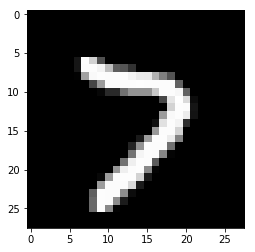

tensor([7, 0, 2, 4, 1, 0, 4, 1, 2, 7, 7, 8, 8, 1, 5, 3, 5, 3, 5, 0, 1, 2, 0, 6,
        9, 4, 7, 5, 3, 0, 6, 2, 4, 2, 6, 4, 2, 0, 7, 2, 0, 4, 9, 3, 7, 8, 7, 4,
        4, 5, 4, 6, 7, 2, 1, 9, 6, 5, 9, 0, 4, 3, 2, 9, 1, 2, 9, 1, 6, 0, 7, 3,
        7, 4, 9, 1, 1, 5, 6, 2, 4, 3, 4, 7, 0, 5, 3, 0, 8, 0, 2, 3, 5, 3, 3, 8,
        0, 4, 4, 2, 0, 7, 4, 5, 9, 0, 8, 7, 5, 3, 4, 9, 0, 3, 3, 0, 3, 7, 9, 4,
        3, 2, 7, 1, 5, 2, 5, 9])


In [3]:
# 展示一张图片

for data, label in train_loader:
    fig = plt.figure()    
    
    print(data.shape)
    plt.imshow(data[0][0], cmap='gray')
    plt.show()

    print(label)
    
    break

下面开始构造VAE

In [4]:
"""
    encoder net Q(z|X)
    其输入为真实数据X，输出为mu(X)和Sigma(X)。
    
    【先验】 我们令z服从高维高斯分布，其均值为0，协方差矩阵为I。即z~N(0,1)
    【假设】 这里我们假设 z|X ~ N(mu(X), Sigma(X))，所以最后优化的一个目标就是
             让这个分布与N(0,1)尽可能靠近（KL散度尽可能小）
             
    Q先从X中产生mu(X)和Sigma(X)，然后z再从中采样（采样在encoder net外）
    
  * Q相当于从数据X中“提取”出一个正态分布，将其视为z所服从的分布。在不断的优化中
    使该分布逐步趋近标准正态分布
    
    
    decoder net P(X|z)
    输入隐变量，输出生成的数据X
"""

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.z_dim = 100
        """
            in encoder
        """
        self.fc1 = nn.Linear(784, 128)   # 784=28*28, size of input image
        self.fc_z_mu = nn.Linear(128, self.z_dim)
    
        # 假设z的各维度相互独立，故Sigma(z)为对角矩阵，故可用向量表示
        self.fc_z_sigma = nn.Linear(128, self.z_dim)
        
        """
            in decoder
        """
        self.fc2 = nn.Linear(self.z_dim, 128)
        self.fc3 = nn.Linear(128, 784)
        
        
    def encoder(self, X):
        h1 = F.relu(self.fc1(X))
        return self.fc_z_mu(h1), self.fc_z_sigma(h1)# 实践中，生成的实际上是log Sigma
    
    
    # 由z|X ~ N(mu(X), Sigma(X))，对z进行采样
    def sample_z(self, mu, logvar):
        std = torch.exp(0.5 * logvar) # e^{(log var)/2} = var^{0.5}
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    
    def decoder(self, z):
        h1 = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h1))
    
    
    def forward(self, X):
        mu, logvar = self.encoder(X.view(-1, 784))
        z = self.sample_z(mu, logvar)
        return self.decoder(z), mu, logvar   # 返回所有求loss时需要用到的变量

下面是训练过程

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-3)


"""
    下面是损失函数，分成两部分
    1. BCE loss -> 使重建的数据和真实数据差别小(相当于前述的极大似然估计过程)
    2. KLD loss -> 使隐变量的分布尽可能接近标准正态分布
"""
def loss_function(recon_x, x, mu, logvar):
    # recon_x是原本的x结果encoder net和decoder net后重建的结果
    BCE_loss = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    
    KLD_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE_loss + KLD_loss

In [6]:
def train(epoch):
    model.train()
    train_loss = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        
        train_loss += loss.item()
        optimizer.step()

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [7]:
for epoch in range(200):
    train(epoch)

====> Epoch: 0 Average loss: 167.1508
====> Epoch: 1 Average loss: 125.6100
====> Epoch: 2 Average loss: 119.0786
====> Epoch: 3 Average loss: 116.4446
====> Epoch: 4 Average loss: 115.0512
====> Epoch: 5 Average loss: 114.1624
====> Epoch: 6 Average loss: 113.6753
====> Epoch: 7 Average loss: 113.3248
====> Epoch: 8 Average loss: 112.9817
====> Epoch: 9 Average loss: 112.8498
====> Epoch: 10 Average loss: 112.6293
====> Epoch: 11 Average loss: 112.5093
====> Epoch: 12 Average loss: 112.2959
====> Epoch: 13 Average loss: 112.2171
====> Epoch: 14 Average loss: 112.0854
====> Epoch: 15 Average loss: 111.9911
====> Epoch: 16 Average loss: 111.8361
====> Epoch: 17 Average loss: 111.8010
====> Epoch: 18 Average loss: 111.8427
====> Epoch: 19 Average loss: 111.5658
====> Epoch: 20 Average loss: 111.5766
====> Epoch: 21 Average loss: 111.4930
====> Epoch: 22 Average loss: 111.5032
====> Epoch: 23 Average loss: 111.4384
====> Epoch: 24 Average loss: 111.5431
====> Epoch: 25 Average loss: 111.3

下面利用训练好的decoder net生成若干图片：

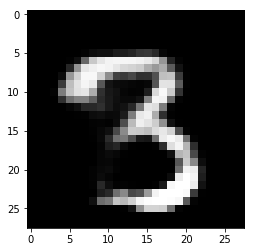

In [17]:
z = torch.randn(100).to(device)

output = model.decoder(z).view(28,28).detach()

plt.imshow(output, cmap='gray')
plt.show()

保存模型：

In [20]:
torch.save(model.state_dict(), 'my_vae.pt')